<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#VQD-Example" data-toc-modified-id="VQD-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VQD Example</a></span></li><li><span><a href="#Do-statistics" data-toc-modified-id="Do-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do statistics</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plots</a></span></li></ul></li><li><span><a href="#Varying-V" data-toc-modified-id="Varying-V-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Varying V</a></span></li><li><span><a href="#Varying-epislon" data-toc-modified-id="Varying-epislon-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Varying epislon</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$
[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [3]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit.aqua.operators import I, X, Y, Z
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

In [102]:
EPSILONS = [.5,2,1]
V = -1
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  0.25 * ZII,
  IZI,
  0.5 * IIZ,
  -0.5 * XXX,
  -0.5 * YYY
])


In [103]:
eigenvalues = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-1.88745861 -1.43614066 -1.03077641 -0.75        0.75        1.03077641
  1.43614066  1.88745861]


# VQD Example

In [ ]:
optimizer = COBYLA(maxiter=10000)
backend = BasicAer.get_backend('qasm_simulator')

Algo = VQD(hamiltonian=hamiltonian,
            n_excited_states=5,
            beta=4.,
            optimizer=optimizer,
            backend=backend)

Algo.run()      
vqd_energies = Algo.energies
vqd_states = Algo.states

Calculating excited state 0
Calculating excited state 1


In [88]:
state_0 = vqd_states[0]
state_1 = vqd_states[1]
state_2 = vqd_states[2]
state_3 = vqd_states[3]
state_4 = vqd_states[4]

In [96]:
from qiskit import execute
state_1.measure_all()
count = execute(state_2, backend=backend, shots=10000).result().get_counts()

In [97]:
count

{'10': 5204, '01': 2331, '11': 2234, '00': 231}

In [94]:
vqd_energies

[-1.953125, -1.0171812500000001, 1.2366546875000006]

In [95]:
print(f"Gap Exact: {(eigenvalues[2] - eigenvalues[1])/2}")
print(f"Gap VQD: {(vqd_energies[2] - vqd_energies[1])/2}")

Gap Exact: 1.0
Gap VQD: 1.1269179687500004


# Do statistics

In [54]:
from tqdm import tqdm

gs = []
es = []

for _ in tqdm(range(50)):
    optimizer = COBYLA()
    backend = BasicAer.get_backend('qasm_simulator')

    Algo = VQD(hamiltonian=hamiltonian,
                n_excited_states=1,
                beta=1.,
                optimizer=optimizer,
                backend=backend)

    Algo.run(0)      
    vqd_energies = Algo.energies
    gs.append(vqd_energies[0])
    es.append(vqd_energies[1])


100%|██████████| 50/50 [1:02:03<00:00, 74.00s/it]


In [44]:
np.savetxt("groundstate.txt", gs)
np.savetxt("excitedstate.txt", es)

In [45]:
print(f"Ground State: {np.round(np.mean(gs),3)} +/- {np.round(np.std(gs),3)} | Expected: {eigenvalues[0]}")
print(f"Excited State: {np.round(np.mean(es),3)} +/- {np.round(np.std(es),3)} | Expected: {eigenvalues[1]}")

Ground State: -1.9 +/- 0.121 | Expected: -2.0
Excited State: -1.09 +/- 0.175 | Expected: -1.0


## Plots

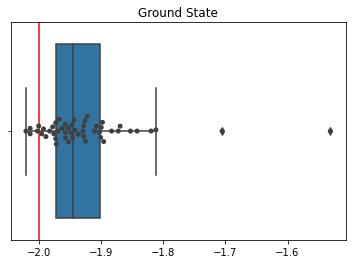

In [59]:
import seaborn as sns

sns.boxplot(x=gs)
ax=sns.swarmplot(x=gs, color="0.25")
ax.set_title("Ground State")
ax.vlines(x=eigenvalues[0], ymin=-10, ymax=10, label='Expected Eigenvalue',color='r')
plt.show()

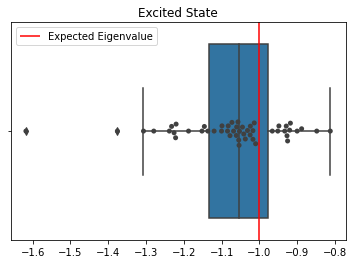

In [58]:
sns.boxplot(x=es)
ax=sns.swarmplot(x=es, color="0.25")
ax.set_title("Excited State")
ax.vlines(x=eigenvalues[1], ymin=-10, ymax=10, label='Expected Eigenvalue',color='r')
plt.legend()
plt.show()

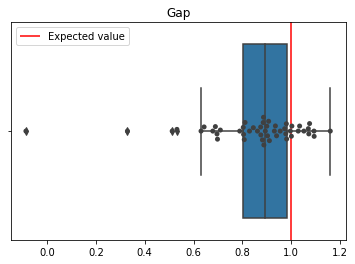

In [60]:
sns.boxplot(x=np.array(es)- np.array(gs))
ax=sns.swarmplot(x=np.array(es)- np.array(gs), color="0.25")
ax.set_title("Gap")
ax.vlines(x=eigenvalues[1] - eigenvalues[0], ymin=-10, ymax=10, label='Expected value',color='r')
plt.legend()
plt.show()

# Varying V

In [12]:
from tqdm import tqdm

def hamiltonian_varying_V(min_V, max_V, points, epsilons):
    energies_VQD = []
    energies_Classical = []
    
    V = np.linspace(min_V, max_V, points)
    
    for v in tqdm(V):
        hamiltonian = BCS_hamiltonian(epsilons, v)
        
        optimizer = COBYLA(maxiter=10000)
        backend = BasicAer.get_backend('qasm_simulator')

        Algo = VQD(hamiltonian=hamiltonian,
                    n_excited_states=2,
                    beta=3.,
                    optimizer=optimizer,
                    backend=backend)
        
        Algo.run(0)      
        quantum = Algo.energies
        energies_VQD.append([quantum[1], quantum[2]])
        classical = classical_solver(hamiltonian)
        energies_Classical.append([classical[1], classical[2]])
    
    return energies_VQD, energies_Classical, V

In [13]:
min_V = -0.
max_V = -1.
points = 5
epsilons = [2,2]
energy_vqd, energy_classical, V = hamiltonian_varying_V(min_V, max_V, points, epsilons)

100%|██████████| 5/5 [11:06<00:00, 131.47s/it]


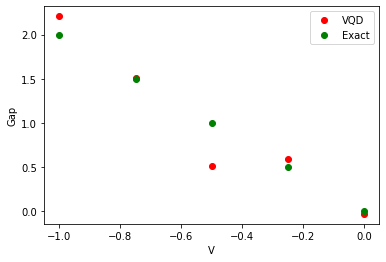

In [14]:
plt.plot(V, [value[1] - value[0] for value in energy_vqd], 'ro', label="VQD")
plt.plot(V, [value[1] - value[0] for value in energy_classical], 'go', label="Exact")
plt.xlabel('V')
plt.ylabel('Gap')
plt.legend()
plt.show()

# Varying epislon

In [10]:
from tqdm import tqdm

def hamiltonian_varying_eps(eps, V):
    energies_VQD = []
    energies_Classical = []
    
    for epsilons in tqdm(eps):
        hamiltonian = BCS_hamiltonian(epsilons, V)
        
        optimizer = COBYLA(maxiter=10000)
        backend = BasicAer.get_backend('qasm_simulator')

        Algo = VQD(hamiltonian=hamiltonian,
                    n_excited_states=1,
                    beta=3.,
                    optimizer=optimizer,
                    backend=backend)
        
        Algo.run(0)      
        uantum = Algo.energies
        energies_VQD.append([quantum[1], quantum[2]])
        classical = classical_solver(hamiltonian)
        energies_Classical.append([classical[1], classical[2]])
    
    return energies_VQD, energies_Classical

In [21]:
eps = [[1,0], [1,1], [1, 1.5], [1, 2.], [1, 2.5]]
V = -1.
energy_vqd, energy_classical = hamiltonian_varying_eps(eps, V)

100%|██████████| 5/5 [06:59<00:00, 85.62s/it]


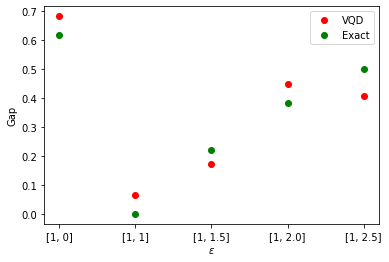

In [24]:
plt.plot([str(v) for v in eps], [value[1] - value[0] for value in energy_vqd], 'ro', label="VQD")
plt.plot([str(v) for v in eps], [value[1] - value[0] for value in energy_classical], 'go', label="Exact")
plt.xlabel('$\epsilon$')
plt.ylabel('Gap')
plt.legend()
plt.show()